<a href="https://colab.research.google.com/github/sakinavohracs/EmotionDetection/blob/master/SemEvalLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Understanding Emotion Detection using upto 2 utterances

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/semeval2019_task3-master

/content/gdrive/My Drive/Colab Notebooks/semeval2019_task3-master


### **Transformers** - Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides state-of-the-art general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet, T5, CTRL...) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over thousands of pretrained models in 100+ languages and deep interoperability between PyTorch & TensorFlow 2.0.

In [5]:
!pip install transformers

     |████████████████████████████████| 778kB 8.4MB/s 
     |████████████████████████████████| 890kB 24.8MB/s 
     |████████████████████████████████| 1.1MB 49.7MB/s 
     |████████████████████████████████| 3.0MB 58.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=ee14e36df88298b6e2d012abfbb57271d015110b2880eaa68e0a8a04397ebd6f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### **Ekphrasis** - Text processing tool, geared towards text from social networks, such as Twitter or Facebook. Ekphrasis performs tokenization, word normalization, word segmentation (for splitting hashtags) and spell correction.

In [7]:
!pip install ekphrasis

     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 184kB 16.5MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp36-none-any.whl size=82843 sha256=10ca915bd57df3d7529aab98ab2bf17d113c77ae043b980b4fb97459b5c9e8bb
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45612 sha256=c4f11b8a3aa32c223a8fbfb788c576aea364cc36768d2aa7924f6ed55d9b811d
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ekphrasis ftfy


In [9]:
!pip install emoji


     |████████████████████████████████| 51kB 4.3MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49714 sha256=56ff53f4392a3aa33d32e1149eb6c28feaf048124b1c9ab1db27ee2f74200508
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [10]:
# export
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig

# fast.ai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# fastbert
from semeval2019_task3.fastbert import *

# dataloader utility function
from data_cleaner import process_pipeline

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


In [11]:
model_class, tokenizer_class, config_class = BertForSequenceClassification, BertTokenizer, BertConfig

# Loading Data

In [12]:
train = pd.read_csv('./data/train.txt', delimiter='\t', encoding='utf-8', index_col='id')
dev = pd.read_csv('./data/dev.txt', delimiter='\t', encoding='utf-8', index_col='id')
test = pd.read_csv('./data/test.txt', delimiter='\t', encoding='utf-8', index_col='id')

In [13]:
train.sample(10)

,turn1,turn2,turn3,label
id,,,,
21601,I don't know😀,I don't know how to maintain it 😛,😂,happy
26058,Now they want me to come up with a slogan for ...,"Nobody got your idea, we been talking about th...",Hmmm. YES! Gunna run with it.,others
13939,I did it twice today and yesterday😔😔,I had a feeling you did,I was really tired so its been so hard,sad
8203,Gotta hit the bed,take a shower!,I took,others
596,hi my love,hi. Same here. Me too love myself.,miss u so much bby,sad
21331,what do you want to know,I don't know xD Do you have pets?,i have a cat,others
24368,I can me 20 April,definitely gonna wish you,I come 20 April,others
15601,I'm girl,I like that,And have my pain full periods,sad
13351,Yes,YAY HAVE FUN 😌😀,I'm very sad,sad


In [14]:
for turn in ['turn1', 'turn2', 'turn3']: 
    train[turn] = train[turn].apply(process_pipeline)
    dev[turn] = dev[turn].apply(process_pipeline)
    test[turn] = test[turn].apply(process_pipeline)

In [16]:
# lookup for labels
EMOS_DIC = {'happy': 0,
            'angry': 1,
            'sad': 2,
            'others': 3}

In [17]:
train.label = train.label.apply(lambda x: EMOS_DIC[x])
dev.label = dev.label.apply(lambda x: EMOS_DIC[x])
test.label = test.label.apply(lambda x: EMOS_DIC[x])

In [18]:
def seed_all(seed_value=42):
    """random seeding Python and torch"""
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [19]:
seed_all()

In [20]:
# setting up the processors for fast.ai TextList 
pretrained_model_name = 'bert-large-uncased-whole-word-masking'

transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = SeqTokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])
tokenize_processor = SeqTokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

transformer_processor = [tokenize_processor, numericalize_processor]

In [21]:
pad_idx = transformer_tokenizer.pad_token_id

In [22]:
# setting up the databunch
databunch = (TextList.from_df(train, cols=['turn1', 'turn2', 'turn3'], processor=transformer_processor)
             .split_none()
             .label_from_df(cols= 'label')
             .databunch(bs=32, pad_first=False, pad_idx=pad_idx))

In [23]:
# batchsizes have to be devidors of the length of the data 
# with TextList objects the last batch would be cut if not
# it would cut the last not size fitting batch out completly
# to validate on new data we have to create a dataloader
# most easiest way is to use the datablock api from FastAi

databunch.valid_dl = (TextList.from_df(dev, cols=['turn1', 'turn2', 'turn3'], processor=transformer_processor)
                      .split_none()
                      .label_from_df(cols= 'label')
                      .databunch(bs=5, pad_first=False, pad_idx=pad_idx)).train_dl

In [24]:
test_dl = (TextList.from_df(test, cols=['turn1', 'turn2', 'turn3'], processor=transformer_processor)
             .split_none()
             .label_from_df(cols= 'label')
             .databunch(bs=7, pad_first=False, pad_idx=pad_idx)).train_dl

## Model Setup

In [25]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 4
config.use_bfloat16 = True # False
print(config)


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "use_bfloat16": true,
  "vocab_size": 30522
}



In [26]:
# create the customized model from the pretrained Bert weights
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [27]:
# the weights result from the balances of the train dataset
weight_list = [0.3198680179, 0.246494733, 0.2484349259, 1.74527696]
weight_label = torch.Tensor(weight_list).cuda()
loss_criterion = nn.CrossEntropyLoss(reduction='none')

In [28]:
# export
def loss_reweight(pred, y_b):
    """cross entropy loss with reweighting"""
    loss_label = loss_criterion(pred, y_b.view(-1).cuda()).cuda()
    loss_label = torch.matmul(torch.gather(weight_label, 0, y_b.view(-1).cuda()), loss_label) / \
                 y_b.view(-1).shape[0]

    return loss_label

In [29]:
# export
def metrics(logits, labels):
    cm = torch.zeros((4,4))
    preds = torch.argmax(logits, dim=1)
    acc = (labels == preds).float().mean()
    for label, pred in zip(labels.view(-1), preds.view(-1)):
        cm[label.long(), pred.long()] += 1
        
    tp = cm.diagonal()[:3].sum()
    fp = cm[:, :3].sum() - tp
    fn = cm[:3, :].sum() - tp 
    return {'val_acc': acc, 'tp': tp, 'fp': fp, 'fn': fn}

def f1_score(tp, fp, fn):
    prec_rec_f1 = {}
    prec_rec_f1['precision'] = tp / (tp + fp)
    prec_rec_f1['recall'] = tp / (tp + fn)
    prec_rec_f1['f1_score'] = 2 * (prec_rec_f1['precision'] * prec_rec_f1['recall']) / (prec_rec_f1['precision'] + prec_rec_f1['recall'])
    return prec_rec_f1

In [30]:
# export
class F1Micro(Callback):
    """custom loss for fast.ai"""
    def on_epoch_begin(self, **kwargs):
        self.out, self.target = torch.empty(0), torch.empty(0)
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        self.out = torch.cat((self.out.type(last_output.cpu().type()), last_output.cpu()))
        self.target = torch.cat((self.target.type(last_target.cpu().type()), last_target.cpu()))
    
    def on_epoch_end(self, last_metrics, **kwargs):
        assert self.out.shape[0] == self.target.shape[0]
        metric = metrics(self.out, self.target)
        f1_dict = f1_score(metric['tp'], metric['fp'], metric['fn'])
        return add_metrics(last_metrics, [f1_dict['f1_score'].numpy()] )

In [31]:
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, F1Micro()],
                  loss_func=loss_reweight,
                  callback_fns=partial(GradientClipping, clip=0.888))

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))
# learner.callbacks.append(SaveModelCallback(learner, every='improvement', monitor='valid_loss', name='best_model'))

# Put learn in FP16 precision mode
learner = learner.to_fp16() # delete the line if fp16 is not wanted

In [32]:
learner.summary()

/content/gdrive/My Drive/Colab Notebooks/semeval2019_task3-master/semeval2019_task3/fastbert.py:88: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  segs = (segment_ids==102).nonzero().cpu().numpy()


CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [64, 1024]           31,254,528 True      
______________________________________________________________________
Embedding            [64, 1024]           524,288    True      
______________________________________________________________________
Embedding            [64, 1024]           2,048      True      
______________________________________________________________________
LayerNorm            [64, 1024]           2,048      True      
______________________________________________________________________
Dropout              [64, 1024]           0          False     
______________________________________________________________________
Linear               [64, 1024]           1,049,600  True      
______________________________________________________________________
Linear               [64, 1024]           1,049,600  True      
_______________________________________

In [33]:
learner.save('untrain')

In [34]:
seed_all() # make sure we have same seeds when rerunning
learner.load('untrain');

In [35]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,f1_micro,time
0,0.174645,0.176008,0.928131,0.747253,05:41
1,0.156200,0.248310,0.919419,0.739179,05:52


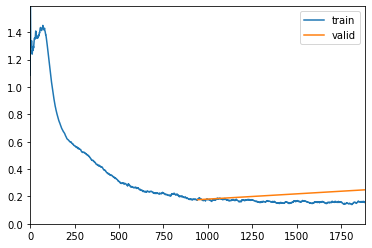

In [36]:
learner.fit_one_cycle(2, max_lr=1e-04, moms=(0.85,0.75))

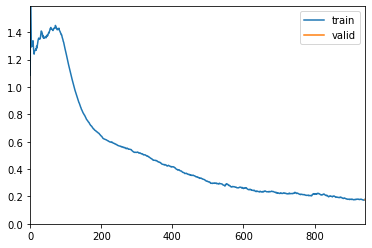

[0.24831858, tensor(0.9194), array(0.739179, dtype=float32)]

In [37]:
# validation on the dev dataset
learner.validate(databunch.valid_dl)

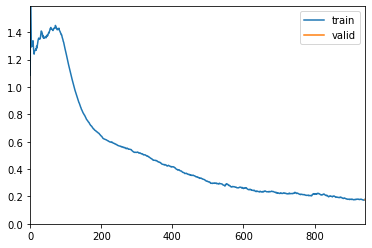

[0.24782757, tensor(0.9214), array(0.746385, dtype=float32)]

In [38]:
# validation on the test dataset
learner.validate(test_dl)

In [40]:
!pip install nbdev

     |████████████████████████████████| 61kB 4.3MB/s 


In [43]:
arr = ['I am tired', 'what is wrong', 'everything']
learner.predict(arr)

(Category tensor(3), tensor(3), tensor([-2.2773, -2.3359, -3.4082,  4.8867]))

In [41]:
from nbdev.export import *
notebook2script()

Converted 00_fastbert.ipynb.
Converted 01_task3.ipynb.
Converted index.ipynb.
